In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

sns.set()

# Métodos de ensamble

Los métodos de ensamble utilizan múltiples algoritmos de aprendizaje para obtener un mejor rendimiento predictivo que el que se podría obtener con cualquiera de los algoritmos de aprendizaje constituyentes por sí solo. 

Esta técnica aprovecha las fortalezas y compensa las debilidades de cada modelo individual al tomar decisiones conjuntas. Al integrar diversos modelos, se atenúan los errores específicos de cada uno, ya que es improbable que todos fallen de la misma manera en el mismo punto. Además, esta estrategia aumenta la robustez del sistema predictivo al proporcionar una especie de chequeo cruzado entre los distintos enfoques de aprendizaje, haciendo al conjunto menos susceptible al sobreajuste y mejorando la generalización a datos no vistos. Es una táctica especialmente útil cuando los datos presentan una gran complejidad y los patrones no son claramente discernibles por un solo modelo. 

## Modelos que votan

Para realizar esta práctica vamos a usar el dataset [**Heart**](https://archive.ics.uci.edu/dataset/45/heart+disease). Recordemos que son mediciones de 302 pacientes, con 13 atributos de variables fisiológicas. Además, contamos con una columna de valores binarios llamada **target** que nos indica si el paciente tiene una enfermedad coronaria o no.

Para la votación vamos a usar todos los modelos que vinimos trabajando:
- Regresión Logística
- k-NN
- Support Vector Machine
- Árbol de clasificación

Para dejar limpios el notebook, vamos a llamar a funciones que traigan los datos ya limpios y se encarguen de entrenar cada modelo (que usaremos para comparar).

In [2]:
import heart 

dataset_heart = heart.HeartDataset()

In [3]:
logistic_trained, metrics_logistic = heart.create_train_logistic_regression(dataset_heart)
svc_trained, metrics_svc = heart.create_train_svc(dataset_heart)
tree_trained, metrics_tree = heart.create_train_tree(dataset_heart)
knn_trained, metrics_knn = heart.create_train_knn(dataset_heart)

Podemos crear un modelo de ensamble de clasificadores que votan usando la clase de Scikit-Learn [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html). Empezamos con un modelo de `hard voting classifier`:

In [4]:
from sklearn.ensemble import VotingClassifier

lr1 = LogisticRegression(random_state=42, class_weight="balanced")
tree1 = DecisionTreeClassifier(max_depth=16, criterion='entropy', min_samples_split=17, min_samples_leaf=3, random_state=42)
svc_1 = SVC(C=5, kernel='linear', probability=True, random_state=42)
knn_1 = KNeighborsClassifier(n_neighbors=35, p=3, weights='distance')

estimators=[('Linear Regression', lr1), 
            ('Tree', tree1), 
            ('Support Vector Classifier', svc_1), 
            ('kNN', knn_1)] 

hard_vot_clas = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

Entrenamos y evaluamos el modelo...

In [5]:
hard_vot_clas.fit(dataset_heart.data_tuple[0], dataset_heart.data_tuple[2])

#OBS: Hard voting classifier no tienen predict_proba() porque es un voto duro
y_pred = hard_vot_clas.predict(dataset_heart.data_tuple[1])

metrics_hard_vot_clas = heart.evaluate_classifier("Hard voting classifier", dataset_heart.data_tuple[-1], y_pred, y_pred)

Usando la misma clase podemos usar un `soft voting classifier`:

In [6]:
lr2 = LogisticRegression(random_state=42, class_weight="balanced")
tree2 = DecisionTreeClassifier(max_depth=16, criterion='entropy', min_samples_split=17, min_samples_leaf=3, random_state=42)
svc_2 = SVC(C=5, kernel='linear', probability=True, random_state=42)
knn_2 = KNeighborsClassifier(n_neighbors=35, p=3, weights='distance')

estimators=[('Linear Regression', lr2), 
            ('Tree', tree2), 
            ('Support Vector Classifier', svc_2), 
            ('kNN', knn_2)] 

soft_vot_clas = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

In [7]:
soft_vot_clas.fit(dataset_heart.data_tuple[0], dataset_heart.data_tuple[2])

y_pred = soft_vot_clas.predict(dataset_heart.data_tuple[1])
y_pred_proba = soft_vot_clas.predict_proba(dataset_heart.data_tuple[1])

metrics_soft_vot_clas = heart.evaluate_classifier("Soft voting classifier", dataset_heart.data_tuple[-1], y_pred, y_pred)

Por otro lado si queremos reemplazar el voto por otro modelo, en Scikit-Learn debemos usar [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html). Para este caso vamos a usar una regresión logística:

In [8]:
from sklearn.ensemble import StackingClassifier

lr3 = LogisticRegression(random_state=42, class_weight="balanced")
tree3 = DecisionTreeClassifier(max_depth=16, criterion='entropy', min_samples_split=17, min_samples_leaf=3, random_state=42)
svc_3 = SVC(C=5, kernel='linear', probability=True, random_state=42)
knn_3 = KNeighborsClassifier(n_neighbors=35, p=3, weights='distance')

estimators=[('Linear Regression', lr3), 
            ('Tree', tree3), 
            ('Support Vector Classifier', svc_3), 
            ('kNN', knn_3)] 

stacking_clas = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)

In [9]:
stacking_clas.fit(dataset_heart.data_tuple[0], dataset_heart.data_tuple[2])

y_pred = soft_vot_clas.predict(dataset_heart.data_tuple[1])
y_pred_proba = soft_vot_clas.predict_proba(dataset_heart.data_tuple[1])

metrics_stacking_clas = heart.evaluate_classifier("Stacking classifier", dataset_heart.data_tuple[-1], y_pred, y_pred)

In [10]:
metrics = pd.DataFrame([
    metrics_logistic,
    metrics_svc,
    metrics_tree,
    metrics_knn,
    metrics_hard_vot_clas,
    metrics_soft_vot_clas,
    metrics_stacking_clas
])

Finalmente podemos ver si mejoramos los resultados combinando los modelos:

In [11]:
metrics.sort_values(by=['accuracy'], ascending=False)

,model,accuracy,auc_score,precision,recall,f1
1,SVC,0.857143,0.896318,0.800000,0.930233,0.860215
4,Hard voting classifier,0.857143,0.858527,0.826087,0.883721,0.853933
0,Regresión Logística,0.846154,0.915213,0.822222,0.860465,0.840909
5,Soft voting classifier,0.824176,0.828488,0.764706,0.906977,0.829787
6,Stacking classifier,0.824176,0.828488,0.764706,0.906977,0.829787
3,kNN,0.813187,0.923450,0.740741,0.930233,0.824742
2,Tree,0.780220,0.800630,0.755556,0.790698,0.772727


Vemos que no mejoramos mucho con respecto a SVC. Esto se debe a que el dataset es pequeño, SVC ya está sacando el mayor jugo posible y los modelos están siendo bastantes parecidos entre si. Nos queda ver si elegimos un umbral diferente para los modelos con salida probabilística podemos mejorar los resultados.

In [12]:
y_prob_lr = logistic_trained.predict_proba(dataset_heart.data_tuple[1])
y_prob_svc =  svc_trained.predict_proba(dataset_heart.data_tuple[1])
y_prob_soft_vot = soft_vot_clas.predict_proba(dataset_heart.data_tuple[1])
y_prob_stacking_clas = stacking_clas.predict_proba(dataset_heart.data_tuple[1])

In [13]:
best_thr_lr = heart.obtain_best_threshold(dataset_heart, y_prob_lr)
best_thr_svc = heart.obtain_best_threshold(dataset_heart, y_prob_svc)
best_thr_soft_vot = heart.obtain_best_threshold(dataset_heart, y_prob_soft_vot)
best_thr_stacking_clas = heart.obtain_best_threshold(dataset_heart, y_prob_stacking_clas)

In [14]:
y_lr = y_prob_lr[:,1].copy()
y_svc = y_prob_svc[:,1].copy()
y_soft_vot = y_prob_soft_vot[:,1].copy()
y_stacking_clas = y_prob_stacking_clas[:,1].copy()

y_lr[y_lr >= best_thr_lr] = 1
y_lr[y_lr < best_thr_lr] = 0
y_svc[y_svc >= best_thr_svc] = 1
y_svc[y_svc < best_thr_svc] = 0
y_soft_vot[y_soft_vot >= best_thr_soft_vot] = 1
y_soft_vot[y_soft_vot < best_thr_soft_vot] = 0
y_stacking_clas[y_stacking_clas >= best_thr_stacking_clas] = 1
y_stacking_clas[y_stacking_clas < best_thr_stacking_clas] = 0

In [15]:
metrics_lr_2 = heart.evaluate_classifier("Regresión Logística", dataset_heart.data_tuple[-1], y_lr, y_prob_lr[:,1])
metrics_svc_2 = heart.evaluate_classifier("SVC", dataset_heart.data_tuple[-1], y_svc, y_prob_svc[:,1])
metrics_soft_vot_clas_2 = heart.evaluate_classifier("Soft voting classifier", dataset_heart.data_tuple[-1], y_soft_vot, y_prob_soft_vot[:,1])
metrics_stacking_clas_2 = heart.evaluate_classifier("Stacking classifier", dataset_heart.data_tuple[-1], y_stacking_clas, y_prob_stacking_clas[:,1])

metrics = pd.DataFrame([
    metrics_lr_2,
    metrics_svc_2,
    metrics_tree,
    metrics_knn,
    metrics_hard_vot_clas,
    metrics_soft_vot_clas_2,
    metrics_stacking_clas_2
])

In [16]:
metrics.sort_values(by=['accuracy'], ascending=False)

,model,accuracy,auc_score,precision,recall,f1
0,Regresión Logística,0.868132,0.915213,0.829787,0.906977,0.866667
1,SVC,0.857143,0.896318,0.800000,0.930233,0.860215
4,Hard voting classifier,0.857143,0.858527,0.826087,0.883721,0.853933
5,Soft voting classifier,0.857143,0.898740,0.812500,0.906977,0.857143
6,Stacking classifier,0.857143,0.908915,0.840909,0.860465,0.850575
3,kNN,0.813187,0.923450,0.740741,0.930233,0.824742
2,Tree,0.780220,0.800630,0.755556,0.790698,0.772727


Finalmente, vemos que el mejor modelo ajustando el umbral es la regresión logística, y luego empatan los ensambles con SVC en exactitud pero varían en otros parámetros. Como se mencionó este dataset no tiene suficiente datos como para aprovechar los efectos del ensamble. 

Veamos las curvas ROC todas juntas:

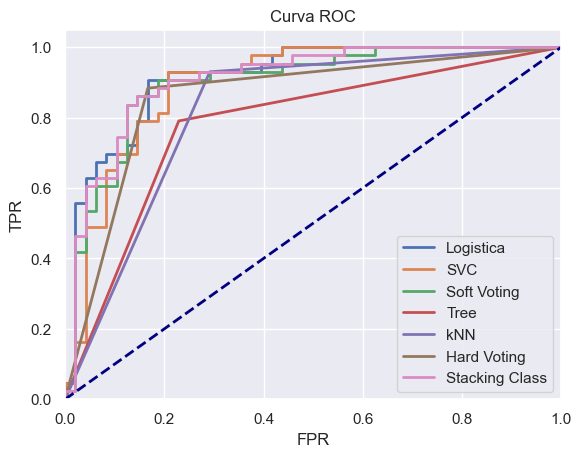

In [17]:
from sklearn.metrics import roc_curve

curves = [
    {"name": "Logistica", "y_prob": logistic_trained.predict_proba(dataset_heart.data_tuple[1])[:,1]},
    {"name": "SVC", "y_prob": svc_trained.predict_proba(dataset_heart.data_tuple[1])[:,1]},
    {"name": "Soft Voting", "y_prob": soft_vot_clas.predict_proba(dataset_heart.data_tuple[1])[:,1]},
    {"name": "Tree", "y_prob": tree_trained.predict(dataset_heart.data_tuple[1])},
    {"name": "kNN", "y_prob": knn_trained.predict(dataset_heart.data_tuple[1])},
    {"name": "Hard Voting", "y_prob": hard_vot_clas.predict(dataset_heart.data_tuple[1])},
    {"name": "Stacking Class", "y_prob": stacking_clas.predict_proba(dataset_heart.data_tuple[1])[:,1]},
]

for dictionary in curves:
    fpr, tpr, _ = roc_curve(dataset_heart.data_tuple[-1], dictionary["y_prob"])
    plt.plot(fpr, tpr, lw=2, label=dictionary["name"])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()